# PROYECTO RECUPERACION DE IMAGENES

Para este proyecto de recuperacion de imagenes la idea original es tener una pagina web conecatada a un backend en donde se pueda subir una imagen como archivo, procesarla y retornar un conjunto de imagenes lo mas similares a la imagen subida

## 1. Importacion de librerias

Para que todas estas librerias esten instaladas se debe correr el comando: 

pip3 install -r requirements.txtx

In [1]:
import os
import tensorflow as tf
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from sklearn.neighbors import NearestNeighbors

## 2. Carga de imagenes y del dataset

Se necesita convertir cada imagen a modo RGB(red, green, blue), redimensionar las imagenes a 256x256 pixeles  

In [13]:
def load_image(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        img = img.resize((256, 256))
        img = np.array(img)
        return img
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def load_dataset(data_dir):
    images = []
    labels = []
    image_paths = []
    label_names = os.listdir(data_dir)
    label_map = {label_name: idx for idx, label_name in enumerate(label_names)}
    
    for label_name in label_names:
        label_dir = os.path.join(data_dir, label_name)
        if os.path.isdir(label_dir):
            for file_name in os.listdir(label_dir):
                if file_name.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(label_dir, file_name)
                    img = load_image(image_path)
                    if img is not None:
                        images.append(img)
                        labels.append(label_map[label_name])
                        image_paths.append(image_path)
    
    print(f"Loaded {len(images)} images with {len(labels)} labels")
    images = np.array(images)
    labels = np.array(labels)
    return images, labels, label_map, image_paths

In [14]:
data_dir = '101_ObjectCategories'
images, labels, label_map, image_paths = load_dataset(data_dir)



Loaded 8677 images with 8677 labels


In [15]:
labels

array([  0,   0,   0, ..., 100, 100, 100])

In [16]:
label_map

{'accordion': 0,
 'airplanes': 1,
 'anchor': 2,
 'ant': 3,
 'barrel': 4,
 'bass': 5,
 'beaver': 6,
 'binocular': 7,
 'bonsai': 8,
 'brain': 9,
 'brontosaurus': 10,
 'buddha': 11,
 'butterfly': 12,
 'camera': 13,
 'cannon': 14,
 'car_side': 15,
 'ceiling_fan': 16,
 'cellphone': 17,
 'chair': 18,
 'chandelier': 19,
 'cougar_body': 20,
 'cougar_face': 21,
 'crab': 22,
 'crayfish': 23,
 'crocodile': 24,
 'crocodile_head': 25,
 'cup': 26,
 'dalmatian': 27,
 'dollar_bill': 28,
 'dolphin': 29,
 'dragonfly': 30,
 'electric_guitar': 31,
 'elephant': 32,
 'emu': 33,
 'euphonium': 34,
 'ewer': 35,
 'Faces': 36,
 'Faces_easy': 37,
 'ferry': 38,
 'flamingo': 39,
 'flamingo_head': 40,
 'garfield': 41,
 'gerenuk': 42,
 'gramophone': 43,
 'grand_piano': 44,
 'hawksbill': 45,
 'headphone': 46,
 'hedgehog': 47,
 'helicopter': 48,
 'ibis': 49,
 'inline_skate': 50,
 'joshua_tree': 51,
 'kangaroo': 52,
 'ketch': 53,
 'lamp': 54,
 'laptop': 55,
 'Leopards': 56,
 'llama': 57,
 'lobster': 58,
 'lotus': 59,
 '

In [17]:
image_paths

['101_ObjectCategories\\accordion\\image_0001.jpg',
 '101_ObjectCategories\\accordion\\image_0002.jpg',
 '101_ObjectCategories\\accordion\\image_0003.jpg',
 '101_ObjectCategories\\accordion\\image_0004.jpg',
 '101_ObjectCategories\\accordion\\image_0005.jpg',
 '101_ObjectCategories\\accordion\\image_0006.jpg',
 '101_ObjectCategories\\accordion\\image_0007.jpg',
 '101_ObjectCategories\\accordion\\image_0008.jpg',
 '101_ObjectCategories\\accordion\\image_0009.jpg',
 '101_ObjectCategories\\accordion\\image_0010.jpg',
 '101_ObjectCategories\\accordion\\image_0011.jpg',
 '101_ObjectCategories\\accordion\\image_0012.jpg',
 '101_ObjectCategories\\accordion\\image_0013.jpg',
 '101_ObjectCategories\\accordion\\image_0014.jpg',
 '101_ObjectCategories\\accordion\\image_0015.jpg',
 '101_ObjectCategories\\accordion\\image_0016.jpg',
 '101_ObjectCategories\\accordion\\image_0017.jpg',
 '101_ObjectCategories\\accordion\\image_0018.jpg',
 '101_ObjectCategories\\accordion\\image_0019.jpg',
 '101_Object

In [39]:
# Realiza la división del dataset incluyendo las rutas de las imágenes
train_images, test_images, train_labels, test_labels, train_paths, test_paths = train_test_split(
    images, labels, image_paths, train_size=0.8, stratify=labels)

print(f"Training set: {len(train_images)} images, Test set: {len(test_images)} images")

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

dataset_info = {
    'description': 'Caltech101 dataset manually loaded',
    'features': {
        'image': {'shape': (256, 256, 3), 'dtype': 'uint8'},
        'label': {'num_classes': len(label_map), 'names': list(label_map.keys())}
    },
    'num_examples': len(images),
    'splits': {
        'train': {'num_examples': len(train_images)},
        'test': {'num_examples': len(test_images)}
    }
}

num_classes = dataset_info['features']['label']['num_classes']

Training set: 6941 images, Test set: 1736 images


In [43]:
dataset_info

{'description': 'Caltech101 dataset manually loaded',
 'features': {'image': {'shape': (256, 256, 3), 'dtype': 'uint8'},
  'label': {'num_classes': 101,
   'names': ['accordion',
    'airplanes',
    'anchor',
    'ant',
    'barrel',
    'bass',
    'beaver',
    'binocular',
    'bonsai',
    'brain',
    'brontosaurus',
    'buddha',
    'butterfly',
    'camera',
    'cannon',
    'car_side',
    'ceiling_fan',
    'cellphone',
    'chair',
    'chandelier',
    'cougar_body',
    'cougar_face',
    'crab',
    'crayfish',
    'crocodile',
    'crocodile_head',
    'cup',
    'dalmatian',
    'dollar_bill',
    'dolphin',
    'dragonfly',
    'electric_guitar',
    'elephant',
    'emu',
    'euphonium',
    'ewer',
    'Faces',
    'Faces_easy',
    'ferry',
    'flamingo',
    'flamingo_head',
    'garfield',
    'gerenuk',
    'gramophone',
    'grand_piano',
    'hawksbill',
    'headphone',
    'hedgehog',
    'helicopter',
    'ibis',
    'inline_skate',
    'joshua_tree',
  

In [41]:
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [42]:
train_dataset = train_dataset.map(preprocess_image).shuffle(1000).batch(32)
test_dataset = test_dataset.map(preprocess_image).batch(32)

# Load VGG16 model with local weights
local_weights_file = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(weights=local_weights_file, include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)


In [44]:
def extract_features(dataset):
    features = []
    labels = []
    for images, lbls in dataset:
        feature_maps = model.predict(images)
        features.append(feature_maps)
        labels.append(lbls.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    print(f"Extracted features: {features.shape}, Labels: {labels.shape}")
    return features, labels

train_features, train_labels = extract_features(train_dataset)
test_features, test_labels = extract_features(test_dataset)

train_features_flat = train_features.reshape(train_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)
print(f"Flattened train features: {train_features_flat.shape}")
print(f"Flattened test features: {test_features_flat.shape}")

# Save and load the features and labels for consistency
np.save('train_features.npy', train_features_flat)
np.save('train_labels.npy', train_labels)
np.save('test_features.npy', test_features_flat)
np.save('test_labels.npy', test_labels)

1/1 [==============================] - 4s 4s/step
Extracted features: (6941, 7, 7, 512), Labels: (6941,)
1/1 [==============================] - 1s 1s/step
Extracted features: (1736, 7, 7, 512), Labels: (1736,)
Flattened train features: (6941, 25088)
Flattened test features: (1736, 25088)


In [45]:
# Load the saved features and labels
train_features_flat = np.load('train_features.npy')
train_labels_flat = np.load('train_labels.npy')
test_features_flat = np.load('test_features.npy')
test_labels_flat = np.load('test_labels.npy')

In [46]:
# Fit NearestNeighbors model
nn_model = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(train_features_flat)

# Extract features from a single query image
query_image, query_label = next(iter(test_dataset.take(1)))
query_image = query_image[10]  # Get the image in the batch
query_image = tf.expand_dims(query_image, axis=0)  # Add batch dimension
query_features = model.predict(query_image).flatten().reshape(1, -1)
query_image_display = query_image.numpy().squeeze()

# Find the nearest neighbors
distances, indices = nn_model.kneighbors(query_features)
print("Indices of nearest neighbors:", indices)
print("Distances to nearest neighbors:", distances)

1/1 [==============================] - 0s 185ms/step
Indices of nearest neighbors: [[1939 4862 2001 1907 2249]]
Distances to nearest neighbors: [[30.14222279 31.27662048 32.5431012  33.52192979 34.08239642]]


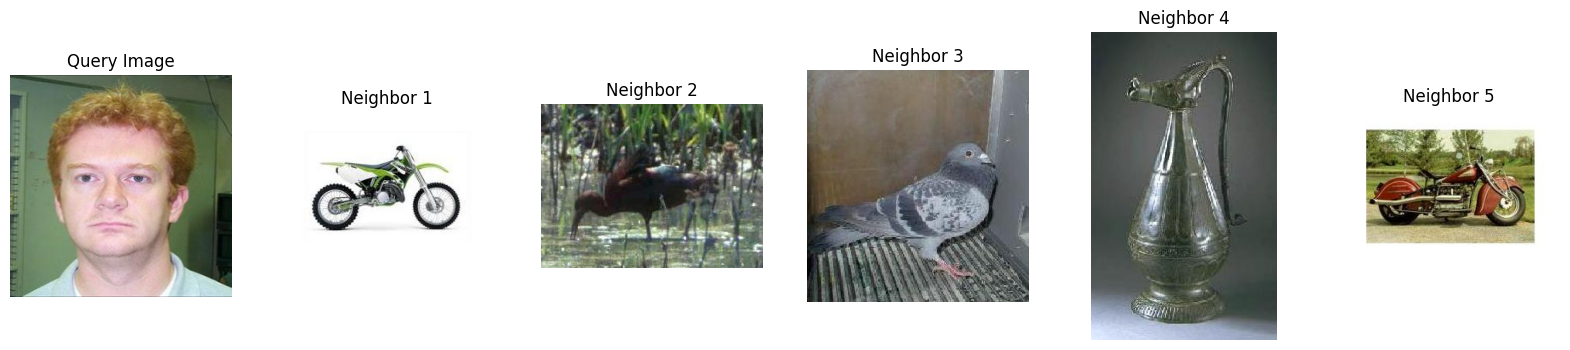

In [47]:
def display_images(query_image, neighbor_indices, image_paths):
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 6, 1)
    plt.imshow(query_image)
    plt.title("Query Image")
    plt.axis('off')
    
    for i, idx in enumerate(neighbor_indices[0]):
        neighbor_image = Image.open(image_paths[idx])
        plt.subplot(1, 6, i+2)
        plt.imshow(neighbor_image)
        plt.title(f"Neighbor {i+1}")
        plt.axis('off')
    
    plt.show()

# Usa test_paths en lugar de image_paths para encontrar los vecinos correctos
display_images(query_image_display, indices, train_paths)